In [182]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import h5py
import keras
import corner

from curve_fit_utils import confidence_band


import scipy.stats
import scipy.optimize



import uproot
from keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

import vector

In [2]:
eventsData = uproot.open("data_Skim_GamGam.root")["mini"]
data_arrays = eventsData.arrays(["photon_pt", "photon_eta", "photon_phi", "photon_E",  "diphoton_mass"], library="np")
df = eventsData.arrays(["photon_pt", "photon_eta", "photon_phi", "photon_E",  "diphoton_mass"], library="pd")
df

,photon_pt,photon_eta,photon_phi,photon_E,diphoton_mass
0,[35529.6875 29579.59765625],[1.0483403205871582 1.2933013439178467],[1.587436556816101 -1.533585548400879],[56908.45703125 57963.6328125],65320.367188
1,[176121.15625 39629.14453125],[-0.8334919810295105 0.0947030708193779],[-0.29423871636390686 0.5672937631607056],[240922.3125 39806.98828125],106420.710938
2,[100427.6796875 95522.5703125],[1.7343542575836182 0.6880435943603516],[0.6559551954269409 -2.4571521282196045],[293338.34375 119039.1328125],223294.968750
3,[38297.3046875 32480.755859375],[0.05254824459552765 -0.8327684998512268],[-1.5148577690124512 1.7095263004302979],[38350.19140625 44409.64453125],77508.187500
4,[45906.0859375 34899.7421875],[0.560444176197052 -0.18553611636161804],[-2.951354503631592 -0.023520486429333687],[53306.27734375 35502.15625],85259.531250
...,...,...,...,...,...
362857,[43045.76953125 40133.7265625],[-0.058136601001024246 -0.9188442826271057],[-2.6306653022766113 1.5349340438842773],[43118.53515625 58301.69921875],81317.265625
362858,[58404.52734375 31240.412109375],[1.2870874404907227 0.5270840525627136],[0.431402325630188 0.8467892408370972],[113839.0390625 35681.3828125],37628.792969
362859,[92575.0390625 86869.7265625],[1.1143873929977417 2.2200980186462402],[2.3199832439422607 -1.107298731803894],[156258.1875 404675.3125],205891.906250
362860,[77078.1171875 46948.61328125],[0.8463831543922424 1.1342076063156128],[-1.699459195137024 0.5268324613571167],[106374.109375 80525.9375],109320.015625


In [3]:

merged_array = np.column_stack((data_arrays["photon_pt"], data_arrays["photon_eta"], data_arrays["photon_phi"], data_arrays["photon_E"],  data_arrays["diphoton_mass"]))

#momentum = events.arrays(["px1", "py1", "pz1"], library="np")
#data = eventsData.arrays(["photon_pt", "photon_eta", "photon_phi", "photon_E",  "diphoton_mass"], library="np")
#df.to_numpy()

data =  merged_array.ravel().reshape(-1,9)

In [90]:
#setting number of features 
N = 9

print(data)
print(data.shape)

#remove the rare events where any of the entries is nan
data_clean = data[~np.isnan(data).any(axis=1), :]

#print(data_clean.shape)

# Standardizing the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_clean)

train_data, test_data = train_test_split(data_scaled, test_size=0.2, random_state=21)
print(np.isnan(train_data).any())

print(train_data)

[[ 3.55296875e+04  2.95795977e+04  1.04834032e+00 ...  5.69084570e+04
   5.79636328e+04  6.53203672e+04]
 [ 1.76121156e+05  3.96291445e+04 -8.33491981e-01 ...  2.40922312e+05
   3.98069883e+04  1.06420711e+05]
 [ 1.00427680e+05  9.55225703e+04  1.73435426e+00 ...  2.93338344e+05
   1.19039133e+05  2.23294969e+05]
 ...
 [ 9.25750391e+04  8.68697266e+04  1.11438739e+00 ...  1.56258188e+05
   4.04675312e+05  2.05891906e+05]
 [ 7.70781172e+04  4.69486133e+04  8.46383154e-01 ...  1.06374109e+05
   8.05259375e+04  1.09320016e+05]
 [ 9.91889453e+04  2.88164297e+04 -1.68336284e+00 ...  2.76210375e+05
   1.34276219e+05  1.09426586e+05]]
(362862, 9)
False
[[-0.6627526  -0.45031264  1.1069458  ... -0.40574992 -0.68292004
  -0.49764243]
 [-0.35281476 -0.42755672  0.12506369 ... -0.6622341  -0.59788144
  -0.42783433]
 [ 0.02647923 -0.18821572 -0.54342026 ... -0.40242243 -0.27166998
  -0.18603283]
 ...
 [ 0.10356814  0.16270305 -0.01325609 ... -0.5043388  -0.51636565
  -0.10738252]
 [-0.47578046 -0.

In [5]:
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

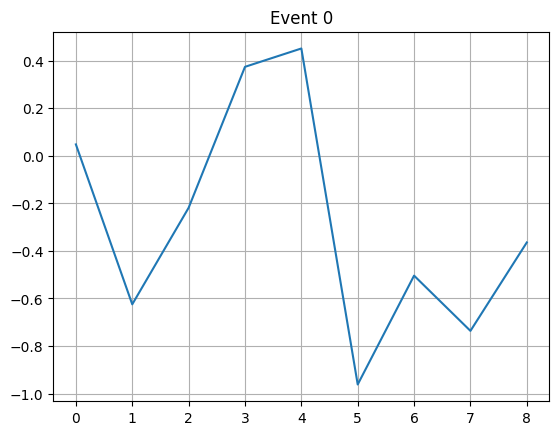

In [6]:
# simple but useful visualisation of a HLT event as a "cardiogram"... "eventogram?"
# would useful but maybe trick to add feature names as labels to x-axis, e.g, "jet4 pt"
fig, ax = plt.subplots()
#ax.set_aspect(0.5)

plt.grid()
ax.plot(np.arange(N), train_data[363])
#ax.set_aspect(1.5)

plt.title("Event 0")
#plt.set_aspect(0.5)

plt.show()

In [7]:
#starting with the simplest possible AE architecture
# first layer has N nodes = N features
# single hidden (bottleneck) layer with N/2
# final layer N nodes = N features

# for probably no good reason, tanh and sigmoid activations give me good 
#results out of the box, while relu didnt train at all, probably a meaningless observation.

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(N, activation="tanh"),
      layers.Dense(N//2, activation="tanh"),
      #layers.Dense(20, activation="relu")
      #layers.Dense(16, activation="relu")
      #layers.Dense(N//4, activation="tanh")
       ])

    self.decoder = tf.keras.Sequential([
      #layers.Dense(20, activation="relu"),
      #layers.Dense(40, activation="relu"),
      #layers.Dense(N/2, activation="tanh"),
      layers.Dense(N, activation="tanh")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [8]:
opt = keras.optimizers.Adam(learning_rate=0.005)

# Compile the WAE model
autoencoder.compile(optimizer=opt, loss="mae")

In [9]:
history = autoencoder.fit(train_data, train_data, 
          epochs=30, 
          batch_size=1024,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5409 - val_loss: 0.4055
Epoch 2/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4017 - val_loss: 0.3935
Epoch 3/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3944 - val_loss: 0.3866
Epoch 4/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3857 - val_loss: 0.3748
Epoch 5/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3684 - val_loss: 0.3519
Epoch 6/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3517 - val_loss: 0.3460
Epoch 7/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3457 - val_loss: 0.3437
Epoch 8/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3427 - val_loss: 0.3390
Epoch 9/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3404 - val_loss: 0.3382
Epoch 10/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3377 - val_loss: 0.3353
Epoch 11/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3367 - val_loss: 0.3350
Epoch 12/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

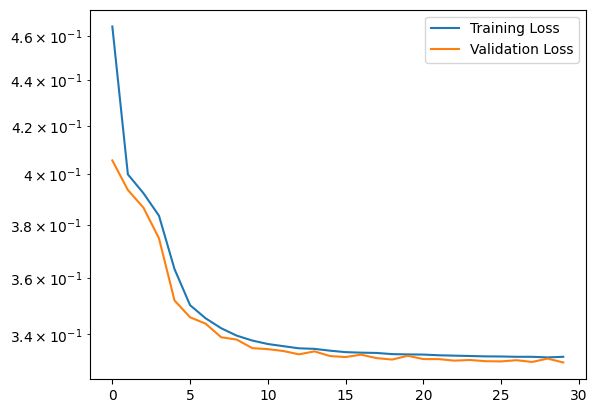

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.yscale("log")
plt.legend()

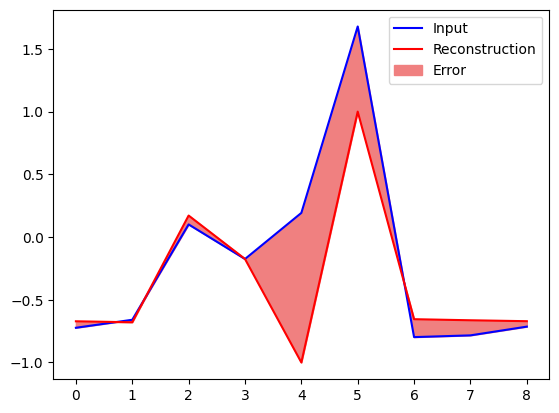

In [11]:
encoded_data = autoencoder.encoder(test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

randIndx = 25

plt.plot(test_data[randIndx], 'b')
#plt.plot(encoded_data[randIndx], 'r')
plt.plot(decoded_data[randIndx], 'r')
#plt.fill_between(np.arange(N), encoded_data[randIndx], test_data[randIndx], color='lightcoral')
plt.fill_between(np.arange(N), decoded_data[randIndx], test_data[randIndx], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

9072/9072 ━━━━━━━━━━━━━━━━━━━━ 7s 720us/step


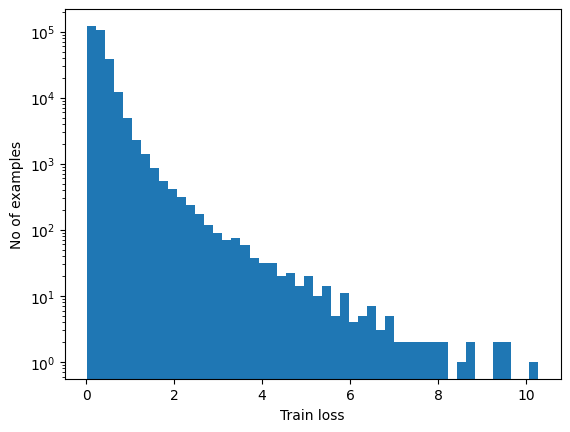

In [12]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.yscale("log")
plt.show()

2268/2268 ━━━━━━━━━━━━━━━━━━━━ 2s 716us/step


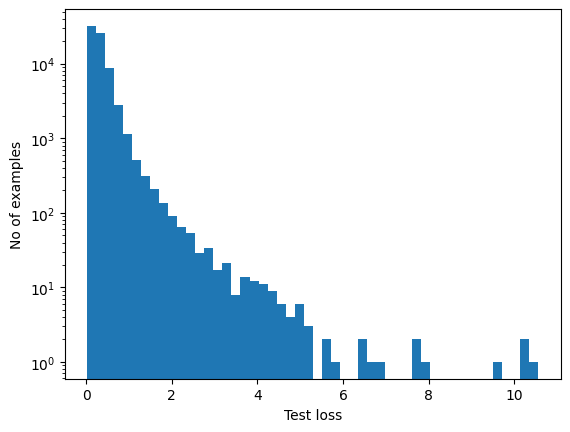

In [13]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)

plt.hist(test_loss[None,:], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.yscale("log")

plt.show()

In [14]:
min_ind = tf.argmin(test_loss)
max_ind = tf.argmax(test_loss)

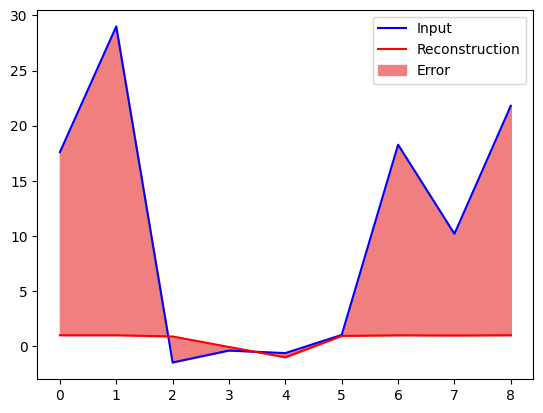

In [15]:
ind = max_ind

plt.plot(test_data[ind], 'b')
plt.plot(decoded_data[ind], 'r')
ratio = (test_data[ind] / decoded_data[ind])
#plt.plot(ratio, 'g')

plt.fill_between(np.arange(N), decoded_data[ind], test_data[ind], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
#plt.yscale("log")
plt.show()

In [16]:
merged_test = np.column_stack((test_data,test_loss))
print(merged_test)

[[-3.09188664e-01  1.01774946e-01  6.76367581e-01 ... -4.62935239e-01
   2.22162530e-02  1.43030211e-01]
 [ 1.69759989e+00 -2.96018481e-01  3.23706985e-01 ... -6.47226036e-01
  -4.01864760e-02  4.06637818e-01]
 [ 5.96167054e-04 -7.88154602e-01 -6.66244268e-01 ...  7.45077431e-01
  -1.43445089e-01  3.85195136e-01]
 ...
 [ 6.72714233e-01  1.82798576e+00 -9.16623995e-02 ...  8.60785663e-01
   1.15380228e+00  4.98380661e-01]
 [-6.62505388e-01 -4.83719051e-01  1.76727903e+00 ...  2.89055079e-01
  -1.18284237e+00  5.06549418e-01]
 [ 6.42460465e-01  3.09735358e-01  9.03347805e-02 ...  1.80589184e-01
   2.89801449e-01  5.10246992e-01]]


In [95]:
# explore relationship between diphoton mass and reconstruction error
train_data_inverted = scaler.inverse_transform(train_data)
train_data_merged = np.column_stack((train_data_inverted, train_loss))

test_data_inverted = scaler.inverse_transform(test_data)
test_data_merged = np.column_stack((test_data_inverted, test_loss))

print(train_data_merged.shape)
print(test_data_merged.shape)
print(data_merged.shape)

data_merged = np.concatenate((train_data_merged, test_data_merged))

(290289, 10)
(72573, 10)
(362862, 10)


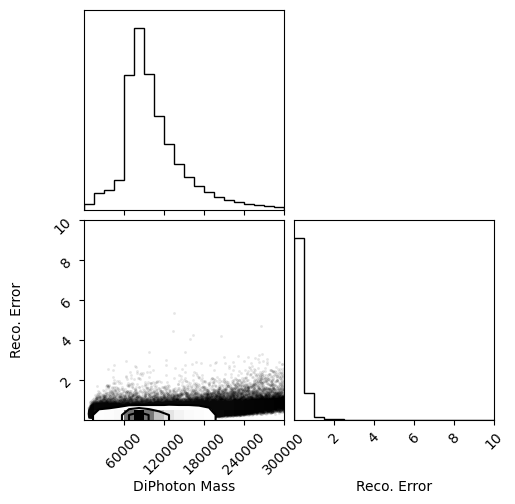

In [98]:
selected_column_ranges = [(8,8),(9,9)] #jet pts and PU vars only for corener plot
selected_columns = np.concatenate([data_merged[:, start:end+1] for start, end in selected_column_ranges], axis=1)

figure = corner.corner(selected_columns, labels=["DiPhoton Mass", "Reco. Error"], range=[(0,300000.0), (0.0,10.0)])

In [166]:
mH = 124894.0
sigmaH = 210.0

#example binning
nBins = 20

minMass = 105000
maxMass = 160000

print(data_merged[:,8].shape)

countsData, edges = np.histogram(data_merged[:,8], bins=nBins, range=(minMass,maxMass))

print(countsData)

#create an array of the centre of each bin, useful for plotting the pdf later
centres = (edges[1:] + edges[:-1]) / 2

print(centres)


(362862,)
[8416 7770 7127 6765 6224 5830 5627 5270 4884 4473 4246 3946 3681 3649
 3305 3110 2881 2735 2576 2408]
[106375. 109125. 111875. 114625. 117375. 120125. 122875. 125625. 128375.
 131125. 133875. 136625. 139375. 142125. 144875. 147625. 150375. 153125.
 155875. 158625.]


In [174]:
def monoExp(x, m, t, b):
    return m * np.exp(t * x) + b

def guess_initial_values(x, y):
    # Estimate the vertical offset (c)
    c = min(y)  # or max(y) depending on the data trend
    
    # Estimate the initial value (a)
    a = y[0] - c
    
    # Estimate the growth rate (b)
    x1, y1 = x[0], y[0]
    x2, y2 = x[10], y[10]

    print((x2 - x1))
    b = np.log((y2 - c) / (y1 - c)) / (x2 - x1)
    
    return a, b, c

27500.0
R² = 0.9990025215605448
[106375. 109125. 111875. 114625. 117375. 120125. 122875. 125625. 128375.
 131125. 133875. 136625. 139375. 142125. 144875. 147625. 150375. 153125.
 155875. 158625.]


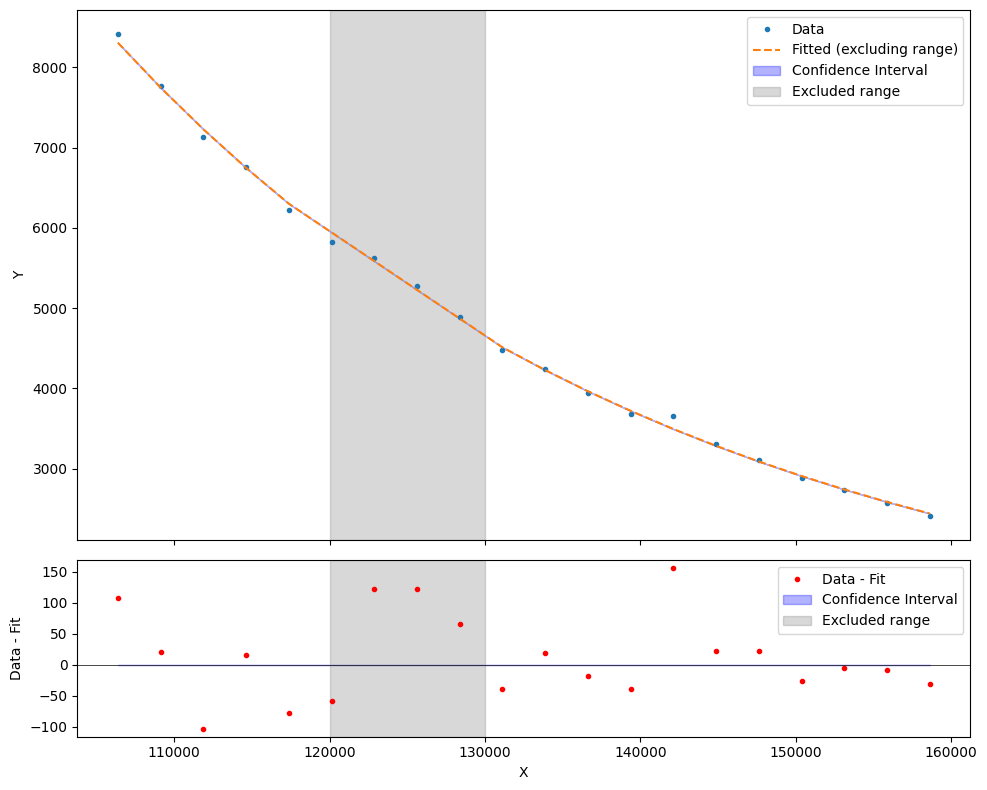

Y = 142060.30009126774 * e^(--2.738806560248862e-05 * x) + 596.1929453262018


In [184]:
# Define the range to exclude from the fit
exclude_start = 120000
exclude_end = 130000

# Create a mask to exclude the specified range
mask = (centres < exclude_start) | (centres > exclude_end)

# Apply the mask to the data
centres_filtered = centres[mask]
countsData_filtered = countsData[mask]

# Perform the fit on the filtered data
p0 = guess_initial_values(centres, countsData)
#p0 = (2000, .1, 50)  # start with values near those we expect
countsData_filtered_unc = np.sqrt(countsData_filtered)
params, cv = scipy.optimize.curve_fit(monoExp, centres_filtered, countsData_filtered, p0,  sigma=countsData_filtered_unc)
m, t, b = params

# Determine the quality of the fit
squaredDiffs = np.square(countsData_filtered - monoExp(centres_filtered, m, t, b))
squaredDiffsFromMean = np.square(countsData_filtered - np.mean(countsData_filtered))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

# Calculate the difference between the data and the fit
diff = countsData - monoExp(centres, m, t, b)

# Calculate the confidence interval
sigma = np.sqrt(np.diag(cv))
n = len(centres_filtered)
alpha = 0.05  # 95% confidence interval
t_crit = scipy.stats.t.ppf(1 - alpha/2, n - len(params))
ci = t_crit * sigma

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot the data and the fit in the upper subplot
ax1.plot(centres, countsData, '.', label="Data")
print(centres)
ax1.plot(centres_filtered, monoExp(centres_filtered, m, t, b), '--', label="Fitted (excluding range)")
ax1.fill_between(centres_filtered, monoExp(centres_filtered, m, t, b) - ci[1], monoExp(centres_filtered, m, t, b) + ci[1],
                 color='blue', alpha=0.3, label="Confidence Interval")
ax1.axvspan(exclude_start, exclude_end, alpha=0.3, color='gray', label="Excluded range")
ax1.set_ylabel("Y")
ax1.legend()

# Plot the difference between the data and the fit in the lower subplot
ax2.plot(centres, diff, '.', color='red', label="Data - Fit")
ax2.fill_between(centres_filtered, -ci[1], ci[1], color='blue', alpha=0.3, label="Confidence Interval")
ax2.axvspan(exclude_start, exclude_end, alpha=0.3, color='gray', label="Excluded range")
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel("X")
ax2.set_ylabel("Data - Fit")
ax2.legend()

plt.tight_layout()
plt.show()

# Inspect the parameters
print(f"Y = {m} * e^(-{t} * x) + {b}")

In [185]:
# fit the model and create confidence_band at 68% CL
upper, lower, f, popt, pcov = confidence_band(monoExp,centres, countsData,
                                              p0=guess_initial_values(centres, countsData), sigma=np.sqrt(countsData), absolute_sigma=True,
                                              full_output=True)

27500.0


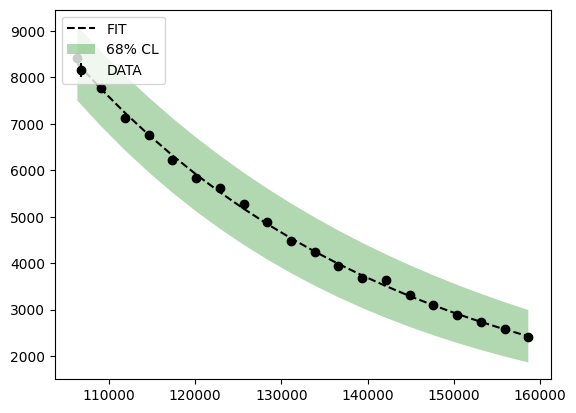

In [189]:
# plot data and bands
from matplotlib import pyplot as plt    
plt.errorbar(centres, countsData, yerr=np.sqrt(countsData), fmt='o', color='black', label='DATA')
plt.plot(centres, f, '--', color='black', label='FIT')
plt.fill_between(centres, lower, upper,
                 facecolor='green', linewidth=0.,
                 alpha=0.3, label='68% CL') # band
plt.legend(loc=2)
plt.show()
    

In [ ]:

b = np.poly1d(np.polyfit(centres, countsData, 4))

#guess a signal integral for illustration purposes
integral = 10112.23

s = (scipy.stats.norm.pdf(centres, mH, sigmaH) * integral)
sb = s+b(centres)

plt.figure()
plt.xlabel("$ m_{\gamma\gamma}$")
plt.ylabel("events per bin")
#plt.plot(centres, s, 'b', linewidth=1, label="Potential Signal")
plt.plot(centres, b(centres), 'k', linewidth=1, linestyle="--", label="Background")
#plt.plot(centres, sb, 'r', linewidth=2, label="Signal+Background")

plt.errorbar(centres, countsData, yerr=np.sqrt(countsData), fmt='o', mfc='k', mec='k',ms=4, mew=0.2, ecolor='k',label="ATLAS Open Data",)
plt.legend()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Mean: ", np.mean(train_loss))
print("Threshold: ", threshold)

Mean:  0.32894555
Threshold:  0.6471424


In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print(preds)
print_stats(preds, test_labels)

tf.Tensor([ True  True  True ...  True  True  True], shape=(72573,), dtype=bool)


NameError: name 'test_labels' is not defined